<a href="https://colab.research.google.com/github/aekanun2020/AdvancedStat/blob/main/2025_ih_EGAT_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ส่วนที่ 1: การตั้งค่าและติดตั้งแพ็คเกจตามกรอบงาน CRISP-DM
# 1. Business Understanding - เข้าใจวัตถุประสงค์ของการพยากรณ์การผลิตไฟฟ้า

# ติดตั้งแพ็คเกจที่จำเป็น
!pip install -q tensorflow pandas numpy matplotlib scikit-learn

# นำเข้าแพ็คเกจที่จำเป็น
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
import os
import datetime

# ตั้งค่าให้แสดงกราฟในโน้ตบุ๊ก
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
warnings.filterwarnings('ignore')

# ตรวจสอบ GPU ที่ใช้ได้
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# ตรวจสอบการใช้งาน GPU
if tf.test.gpu_device_name():
    print('GPU found')
    print("GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("No GPU found, using CPU instead")

TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU found
GPU Device: /device:GPU:0


สร้างชุดข้อมูลจำลองจำนวน 26281 แถว

ตัวอย่างข้อมูล 5 แถวแรก:

ข้อมูลเชิงสถิติของชุดข้อมูล:

จำนวนค่าที่หายไปในแต่ละคอลัมน์:


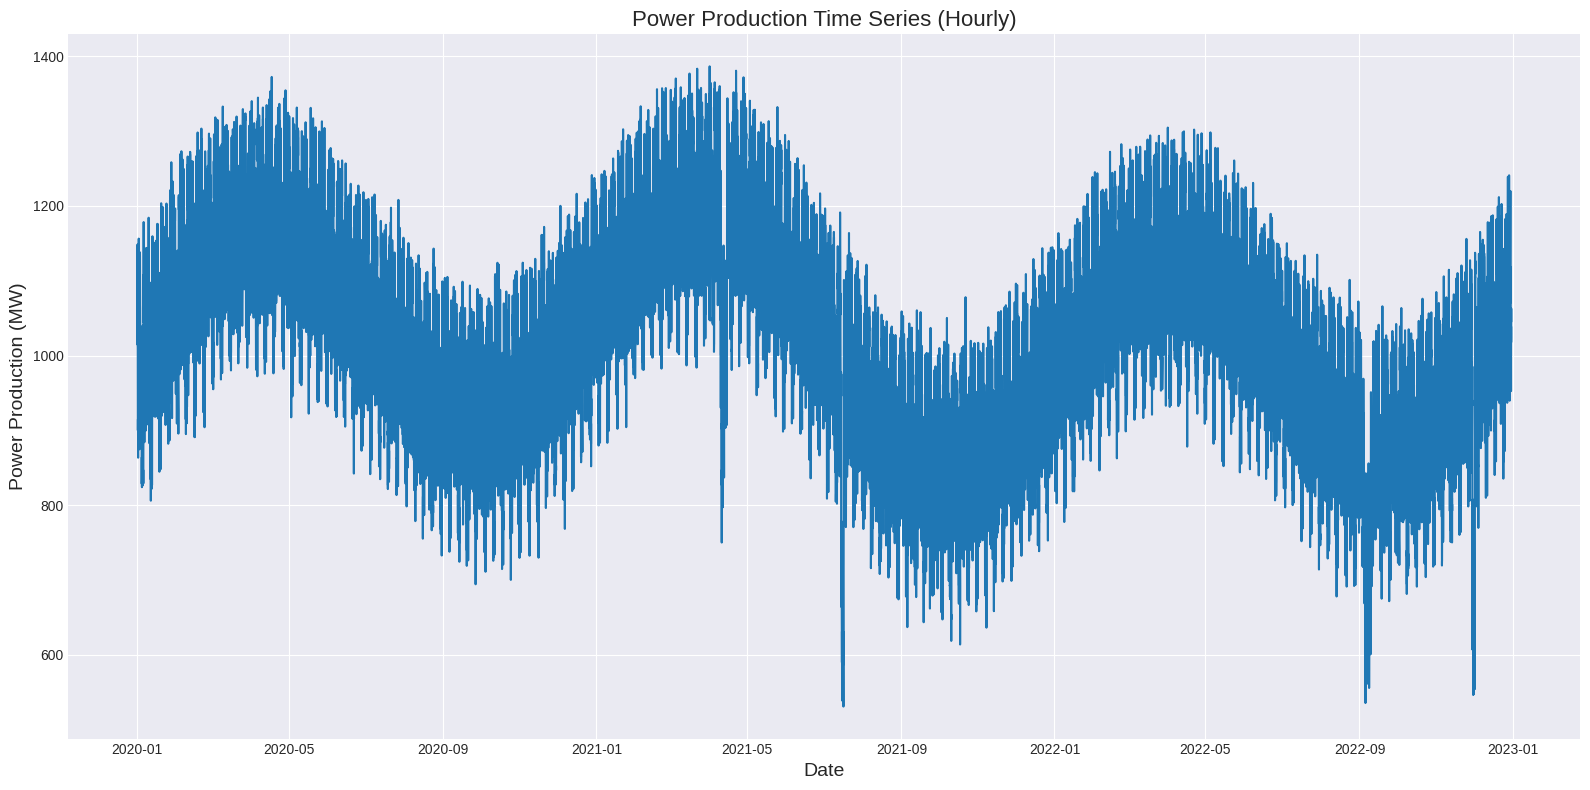

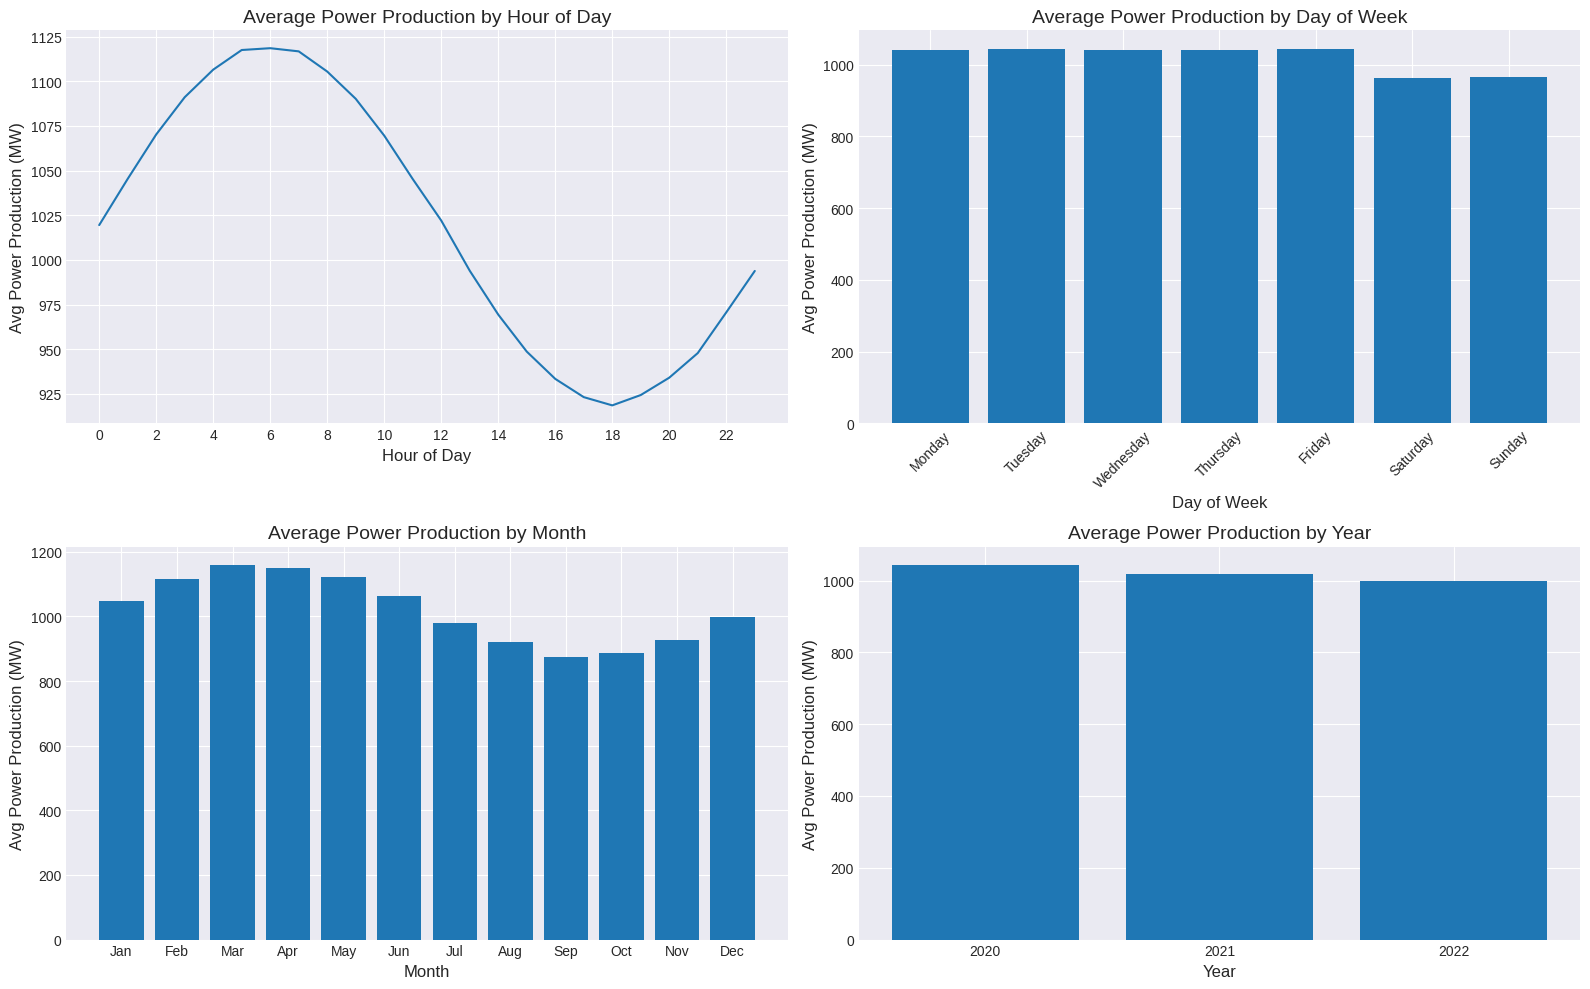

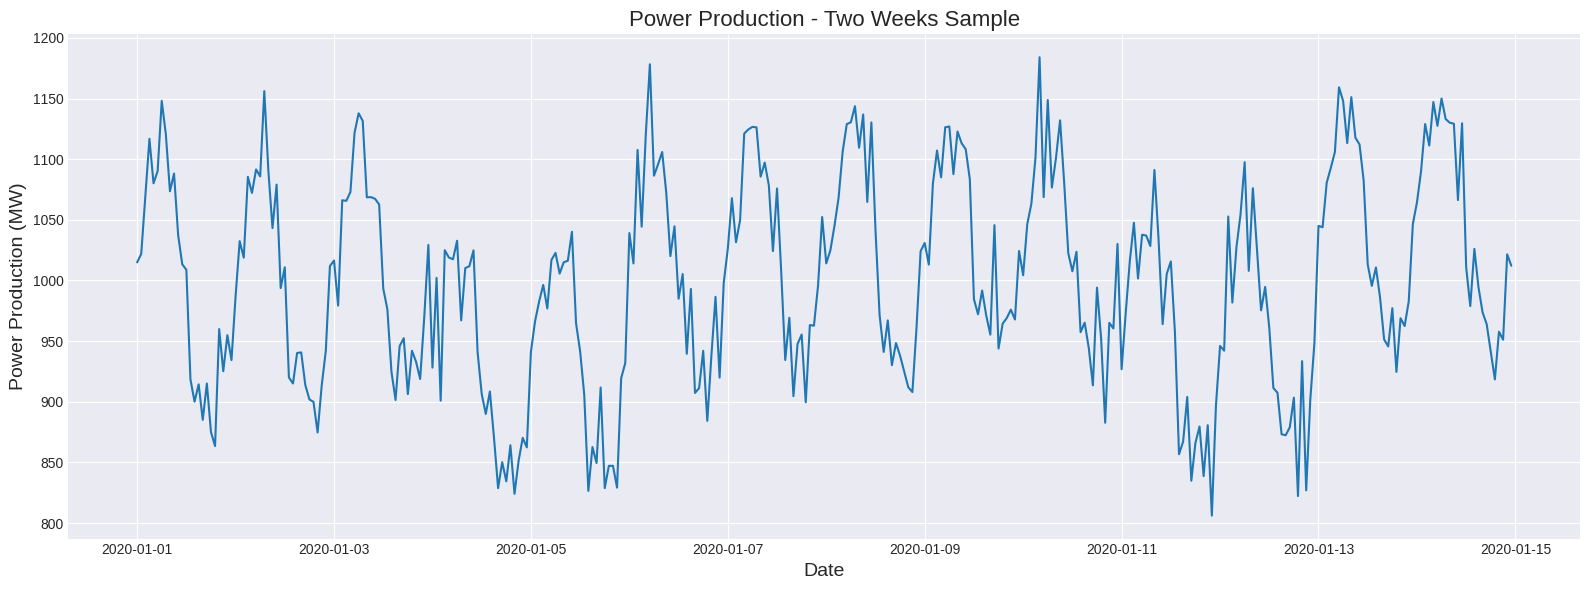

In [2]:
# ส่วนที่ 2: การทำความเข้าใจข้อมูล (Data Understanding)
# สร้างชุดข้อมูลจำลองและวิเคราะห์ลักษณะของข้อมูล

# ฟังก์ชันสร้างข้อมูลจำลองการผลิตไฟฟ้า
def create_power_production_data(start_date='2020-01-01', end_date='2022-12-31'):
    # สร้างช่วงวันที่
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    df = pd.DataFrame(index=date_range)

    # 1. แนวโน้ม (Trend) - การเติบโตของความต้องการไฟฟ้า 3% ต่อปี
    days = (df.index - df.index[0]).total_seconds() / (24*60*60)
    daily_growth = (1.03)**(1/365)  # การเติบโต 3% ต่อปี
    trend = 1000 * (daily_growth ** (days))

    # 2. ฤดูกาล (Seasonality)
    # ฤดูกาลรายปี - ความต้องการไฟฟ้าเพิ่มขึ้นในฤดูร้อนและฤดูหนาว
    yearly_seasonality = 150 * np.sin(2 * np.pi * days / 365)

    # ฤดูกาลรายวัน - สูงในช่วงกลางวัน ต่ำในช่วงกลางคืน
    hour_of_day = df.index.hour
    daily_pattern = 100 * np.sin(np.pi * hour_of_day / 12)

    # ฤดูกาลรายสัปดาห์ - ต่ำในวันหยุดสุดสัปดาห์
    day_of_week = df.index.dayofweek
    weekly_pattern = np.where(day_of_week >= 5, -80, 0)  # ลด 80 หน่วยในวันเสาร์-อาทิตย์

    # 3. วัฏจักร (Cyclical) - วัฏจักรทางเศรษฐกิจประมาณ 3 ปี
    cycle_period = 3 * 365  # วัฏจักร 3 ปี
    cyclical = 70 * np.sin(2 * np.pi * days / cycle_period)

    # 4. Irregular Component - ความผันผวนทั่วไปและเหตุการณ์พิเศษ
    np.random.seed(42)  # ตั้งค่า seed สำหรับการสร้างค่าแบบสุ่ม
    irregular = np.random.normal(0, 30, len(df))

    # เพิ่มเหตุการณ์พิเศษบางวัน (เช่น ไฟดับหรือซ่อมบำรุงโรงไฟฟ้า)
    special_events = pd.Series(0, index=df.index)

    # สมมติว่ามีการซ่อมบำรุงโรงไฟฟ้าในบางช่วง
    maintenance_periods = [
        ('2021-04-10', '2021-04-15'),
        ('2022-09-05', '2022-09-10')
    ]
    for start, end in maintenance_periods:
        mask = (df.index >= start) & (df.index <= end)
        special_events[mask] = -200  # ลดการผลิตลง 200 หน่วย

    # สมมติว่ามีเหตุการณ์ฉุกเฉินทำให้โรงไฟฟ้าหยุดทำงานชั่วคราว
    emergency_dates = ['2021-07-15', '2022-11-30']
    for date in emergency_dates:
        # ส่งผลกระทบ 48 ชั่วโมง
        start_date = pd.Timestamp(date)
        end_date = start_date + pd.Timedelta(hours=48)
        mask = (df.index >= start_date) & (df.index < end_date)
        special_events[mask] = -350  # ลดการผลิตลง 350 หน่วย

    # รวมองค์ประกอบทั้งหมด
    df['power_production'] = trend + yearly_seasonality + daily_pattern + weekly_pattern + cyclical + irregular + special_events

    # ปรับให้ค่าต่ำสุดไม่น้อยกว่า 100 (กำลังการผลิตขั้นต่ำ)
    df['power_production'] = df['power_production'].clip(lower=100)

    # เพิ่มคอลัมน์ข้อมูลเวลาที่ง่ายต่อการวิเคราะห์
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_week'] = df.index.dayofweek
    df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    return df

# สร้างข้อมูล
power_data = create_power_production_data()
print(f"สร้างชุดข้อมูลจำลองจำนวน {len(power_data)} แถว")

# แสดงข้อมูล 5 แถวแรก
print("\nตัวอย่างข้อมูล 5 แถวแรก:")
power_data.head()

# สรุปสถิติของข้อมูล
print("\nข้อมูลเชิงสถิติของชุดข้อมูล:")
power_data.describe()

# ตรวจสอบค่าที่หายไป
print("\nจำนวนค่าที่หายไปในแต่ละคอลัมน์:")
power_data.isnull().sum()

# แสดงกราฟชุดข้อมูลทั้งหมด
plt.figure(figsize=(16, 8))
plt.plot(power_data.index, power_data['power_production'])
plt.title('Power Production Time Series (Hourly)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Power Production (MW)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# วิเคราะห์รูปแบบตามช่วงเวลา
plt.figure(figsize=(16, 10))

# แนวโน้มรายชั่วโมง
plt.subplot(2, 2, 1)
hourly_avg = power_data.groupby('hour')['power_production'].mean()
plt.plot(hourly_avg.index, hourly_avg.values)
plt.title('Average Power Production by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Avg Power Production (MW)', fontsize=12)
plt.xticks(range(0, 24, 2))
plt.grid(True)

# แนวโน้มรายวันในสัปดาห์
plt.subplot(2, 2, 2)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = power_data.groupby('day_of_week')['power_production'].mean()
plt.bar(day_names, daily_avg.values)
plt.title('Average Power Production by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Avg Power Production (MW)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# แนวโน้มรายเดือน
plt.subplot(2, 2, 3)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg = power_data.groupby('month')['power_production'].mean()
plt.bar(month_names, monthly_avg.values)
plt.title('Average Power Production by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Avg Power Production (MW)', fontsize=12)
plt.grid(True)

# แนวโน้มรายปี
plt.subplot(2, 2, 4)
yearly_avg = power_data.groupby('year')['power_production'].mean()
plt.bar(yearly_avg.index.astype(str), yearly_avg.values)
plt.title('Average Power Production by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Avg Power Production (MW)', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# แสดงข้อมูลเฉพาะช่วง 2 สัปดาห์เพื่อดูรูปแบบรายวัน
plt.figure(figsize=(16, 6))
sample_week = power_data.loc['2020-01-01':'2020-01-14']
plt.plot(sample_week.index, sample_week['power_production'])
plt.title('Power Production - Two Weeks Sample', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Power Production (MW)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
# ส่วนที่ 3: การเตรียมข้อมูล (Data Preparation)
# เตรียมข้อมูลสำหรับโมเดล LSTM รวมถึงการแปลงข้อมูลและการสร้างลำดับเวลา

# ส่วนนี้ต้องรันหลังจากส่วนที่ 2 เพื่อให้มีตัวแปร power_data แล้ว

# แยกข้อมูลสำหรับการสร้างโมเดล
data = power_data[['power_production']].copy()

# เพิ่ม feature เพิ่มเติมที่เป็นประโยชน์สำหรับ time series โดยใช้การแปลงแบบ cyclical encoding
data['hour_sin'] = np.sin(2 * np.pi * power_data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * power_data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * power_data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * power_data['day_of_week'] / 7)
data['month_sin'] = np.sin(2 * np.pi * power_data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * power_data['month'] / 12)
data['weekend'] = power_data['weekend']

print("คอลัมน์ที่ใช้ในการสร้างโมเดล:")
print(data.columns.tolist())
print("\nตัวอย่างข้อมูลที่เตรียมไว้:")
print(data.head())

# ปรับข้อมูลให้มีค่าระหว่าง 0-1 (Normalization) ซึ่งจำเป็นสำหรับโมเดล LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print("\nรูปร่างข้อมูลหลังการแปลง:", scaled_data.shape)
print("ตัวอย่างข้อมูลหลังการแปลง (5 แถวแรก):")
print(scaled_data[:5])

# แบ่งข้อมูลเป็นชุดสำหรับฝึกโมเดล (80%) และชุดทดสอบ (20%)
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print(f"\nจำนวนข้อมูลที่ใช้สร้างโมเดล: {train_size}")
print(f"จำนวนข้อมูลที่ใช้ทดสอบโมเดล: {test_size}")
print(f"จำนวนตัวแปรที่ใช้: {scaled_data.shape[1]}")

# ฟังก์ชันสร้างชุดข้อมูลสำหรับ LSTM
def create_sequences(data, seq_length, pred_length):
    """
    สร้างลำดับข้อมูลสำหรับโมเดล LSTM

    Parameters:
    data (numpy.ndarray): ข้อมูลที่ผ่านการแปลงแล้ว
    seq_length (int): จำนวนจุดข้อมูลที่ใช้ในการพยากรณ์ (look-back period)
    pred_length (int): จำนวนจุดข้อมูลที่ต้องการพยากรณ์ (forecast horizon)

    Returns:
    tuple: (X, y) คู่ของข้อมูลนำเข้าและผลลัพธ์ที่ต้องการ
    """
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + pred_length, 0])  # เฉพาะค่า power_production
    return np.array(X), np.array(y)

# กำหนดความยาวของข้อมูลย้อนหลังที่ใช้ในการพยากรณ์ (7 วัน)
seq_length = 7 * 24  # 168 ชั่วโมง
# กำหนดจำนวนชั่วโมงที่ต้องการพยากรณ์ล่วงหน้า
pred_length = 24  # 24 ชั่วโมง

# สร้างชุดข้อมูลสำหรับโมเดล
X_train, y_train = create_sequences(train_data, seq_length, pred_length)
X_test, y_test = create_sequences(test_data, seq_length, pred_length)

print(f"\nรูปร่างข้อมูลฝึกสอน: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"รูปร่างข้อมูลทดสอบ: X_test: {X_test.shape}, y_test: {y_test.shape}")

# บันทึกข้อมูลให้ส่วนถัดไปใช้ (optional)
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
# บันทึก scaler ไว้ใช้ในการแปลงค่ากลับในภายหลัง
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nบันทึกข้อมูลเรียบร้อยแล้ว พร้อมสำหรับการสร้างโมเดล")

คอลัมน์ที่ใช้ในการสร้างโมเดล:
['power_production', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'weekend']

ตัวอย่างข้อมูลที่เตรียมไว้:
                     power_production  hour_sin  hour_cos   day_sin   day_cos  \
2020-01-01 00:00:00       1014.901425  0.000000  1.000000  0.974928 -0.222521   
2020-01-01 01:00:00       1021.861675  0.258819  0.965926  0.974928 -0.222521   
2020-01-01 02:00:00       1069.686054  0.500000  0.866025  0.974928 -0.222521   
2020-01-01 03:00:00       1116.784671  0.707107  0.707107  0.974928 -0.222521   
2020-01-01 04:00:00       1080.088735  0.866025  0.500000  0.974928 -0.222521   

                     month_sin  month_cos  weekend  
2020-01-01 00:00:00        0.5   0.866025        0  
2020-01-01 01:00:00        0.5   0.866025        0  
2020-01-01 02:00:00        0.5   0.866025        0  
2020-01-01 03:00:00        0.5   0.866025        0  
2020-01-01 04:00:00        0.5   0.866025        0  

รูปร่างข้อมูลหลังการแปลง: (2628

โหลดข้อมูลจากไฟล์เรียบร้อย
รูปร่างข้อมูลฝึกสอน: X_train: (20833, 168, 8), y_train: (20833, 24)
รูปร่างข้อมูลทดสอบ: X_test: (5066, 168, 8), y_test: (5066, 24)
จำนวนตัวอย่างฝึกสอน: 20833
ความยาวลำดับเวลา (time steps): 168
จำนวนคุณลักษณะ (features): 8
จำนวนชั่วโมงในการพยากรณ์: 24


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 168, 100)       │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,024 (293.06 KB)

 Trainable params: 75,024 (293.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
519/521 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0467

521/521 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0466 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 2/50
519/521 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0068

521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0068 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049

521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0049 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/50
518/521 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0040

521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0040 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/50
518/521 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035

521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0035 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/50
517/521 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029

521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0029 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 7/50
518/521 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026

521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0026 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 8/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0024 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 9/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 10/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0023 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 11/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0022 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 12/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0022 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 13/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0021 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 14/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0020 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 15/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0021 - val_loss: 0.0017 - learning_rate: 

521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0020 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 18/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0020 - val_loss: 0.0015 - learning_rate: 2.5000e-04
Epoch 19/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0021 - val_loss: 0.0015 - learning_rate: 2.5000e-04
Epoch 20/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020

521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 2.5000e-04
Epoch 21/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0020 - val_loss: 0.0015 - learning_rate: 2.5000e-04
Epoch 22/50
520/521 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020

521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 2.5000e-04
Epoch 23/50
518/521 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019

521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 1.2500e-04
Epoch 24/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0019 - val_loss: 0.0015 - learning_rate: 1.2500e-04
Epoch 25/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.2500e-04
Epoch 26/50
518/521 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020

521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.2500e-04
Epoch 27/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.2500e-04
Epoch 28/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0019 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 29/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0020 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 30/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 31/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 32/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 33/50
518/521 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019

521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 34/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 35/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 36/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0019 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 37/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 38/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 39/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 40/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 41/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0020 - val_los

521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 43/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0019 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 44/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 45/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 46/50
518/521 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019

521/521 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 47/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 48/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 49/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 50/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 1.0000e-04


บันทึกโมเดลเรียบร้อยแล้ว


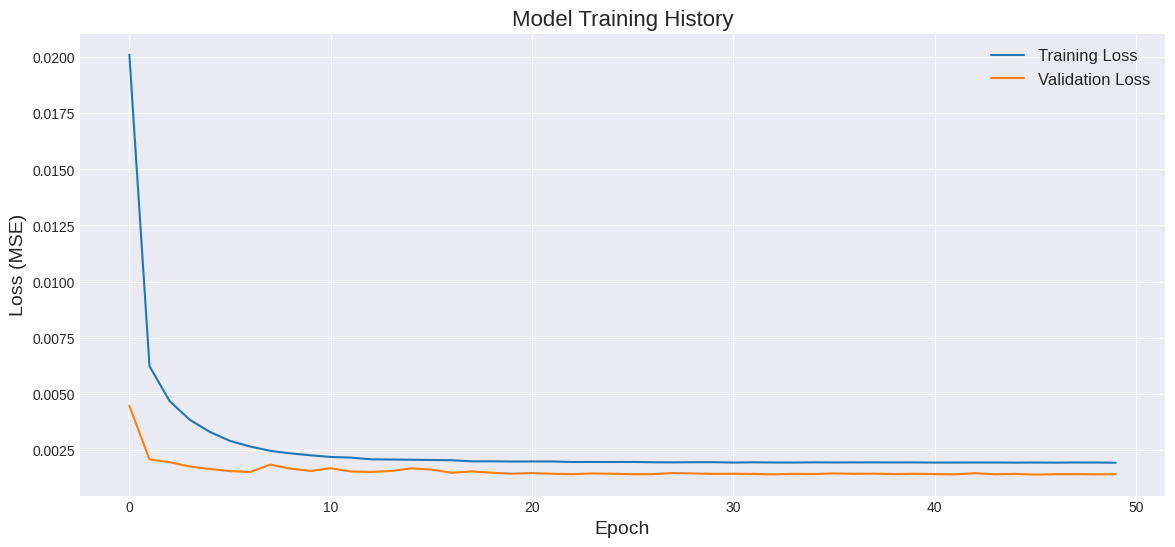

ค่า Loss ต่ำสุดในการฝึก: 0.001935
ค่า Validation Loss ต่ำสุด: 0.001407
จำนวน Epochs ที่ใช้จริง: 50
บันทึกประวัติการฝึกโมเดลเรียบร้อยแล้ว


In [4]:
# ส่วนที่ 4: การสร้างโมเดล (Modeling)
# สร้างและฝึกโมเดล LSTM สำหรับการพยากรณ์การผลิตไฟฟ้า

# โหลดข้อมูลที่เตรียมไว้จากส่วนที่ 3 (หากต้องการรันแยก)
try:
    X_train = np.load('X_train.npy')
    y_train = np.load('y_train.npy')
    X_test = np.load('X_test.npy')
    y_test = np.load('y_test.npy')
    print("โหลดข้อมูลจากไฟล์เรียบร้อย")
except FileNotFoundError:
    print("ไม่พบไฟล์ข้อมูล กรุณารันส่วนที่ 3 ก่อน หรือกำหนดตัวแปรเหล่านี้เอง")

# แสดงข้อมูลที่ใช้ในการสร้างโมเดล
print(f"รูปร่างข้อมูลฝึกสอน: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"รูปร่างข้อมูลทดสอบ: X_test: {X_test.shape}, y_test: {y_test.shape}")

# ดูคุณสมบัติของข้อมูล
print(f"จำนวนตัวอย่างฝึกสอน: {X_train.shape[0]}")
print(f"ความยาวลำดับเวลา (time steps): {X_train.shape[1]}")
print(f"จำนวนคุณลักษณะ (features): {X_train.shape[2]}")
print(f"จำนวนชั่วโมงในการพยากรณ์: {y_train.shape[1]}")

# สร้างโมเดล LSTM
def create_lstm_model(seq_length, features, pred_length):
    """
    สร้างโมเดล LSTM สำหรับการพยากรณ์

    Parameters:
    seq_length (int): จำนวนจุดข้อมูลย้อนหลังที่ใช้
    features (int): จำนวนคุณลักษณะของข้อมูล
    pred_length (int): จำนวนจุดข้อมูลที่ต้องการพยากรณ์

    Returns:
    model: โมเดล LSTM ที่สร้างขึ้น
    """
    model = Sequential([
        # ชั้นแรก: LSTM พร้อม return_sequences เพื่อส่งต่อข้อมูลไปยังชั้นถัดไป
        LSTM(100, return_sequences=True, input_shape=(seq_length, features)),
        Dropout(0.2),  # ป้องกัน overfitting

        # ชั้นที่สอง: LSTM ที่ให้ผลลัพธ์เป็นเวกเตอร์
        LSTM(50),
        Dropout(0.2),  # ป้องกัน overfitting

        # ชั้นสุดท้าย: Dense layer ที่ให้ผลลัพธ์เป็นค่าพยากรณ์ตามจำนวนที่ต้องการ
        Dense(pred_length)
    ])

    # คอมไพล์โมเดล
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# สร้างโมเดล
model = create_lstm_model(X_train.shape[1], X_train.shape[2], y_train.shape[1])
model.summary()

# กำหนด callbacks เพื่อปรับปรุงการฝึกโมเดล
callbacks = [
    # หยุดเมื่อไม่มีการปรับปรุง
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

    # ลดอัตราการเรียนรู้เมื่อผลการฝึกไม่ดีขึ้น
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001),

    # บันทึกโมเดลที่ดีที่สุด
    ModelCheckpoint('lstm_power_model.h5', monitor='val_loss', save_best_only=True)
]

# ฝึกโมเดล
history = model.fit(
    X_train, y_train,
    epochs=50,  # จำนวนรอบในการฝึก
    batch_size=32,  # ขนาดของ batch
    validation_split=0.2,  # สัดส่วนข้อมูลสำหรับตรวจสอบ
    callbacks=callbacks,  # callbacks ที่กำหนดไว้
    verbose=1  # แสดงรายละเอียดระหว่างการฝึก
)

# บันทึกโมเดลสุดท้าย
model.save('lstm_power_final_model.h5')
print("บันทึกโมเดลเรียบร้อยแล้ว")

# แสดงกราฟการฝึกโมเดล
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# แสดงข้อมูลสรุปการฝึกโมเดล
print(f"ค่า Loss ต่ำสุดในการฝึก: {min(history.history['loss']):.6f}")
print(f"ค่า Validation Loss ต่ำสุด: {min(history.history['val_loss']):.6f}")
print(f"จำนวน Epochs ที่ใช้จริง: {len(history.history['loss'])}")

# บันทึกประวัติการฝึกโมเดล (optional)
import json
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)
print("บันทึกประวัติการฝึกโมเดลเรียบร้อยแล้ว")

โหลดข้อมูลและโมเดลเรียบร้อย
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
รูปร่างผลลัพธ์การพยากรณ์: (5066, 24)
Mean Absolute Error (MAE): 28.97 MW
Root Mean Squared Error (RMSE): 43.05 MW
Mean Absolute Percentage Error (MAPE): 3.24%


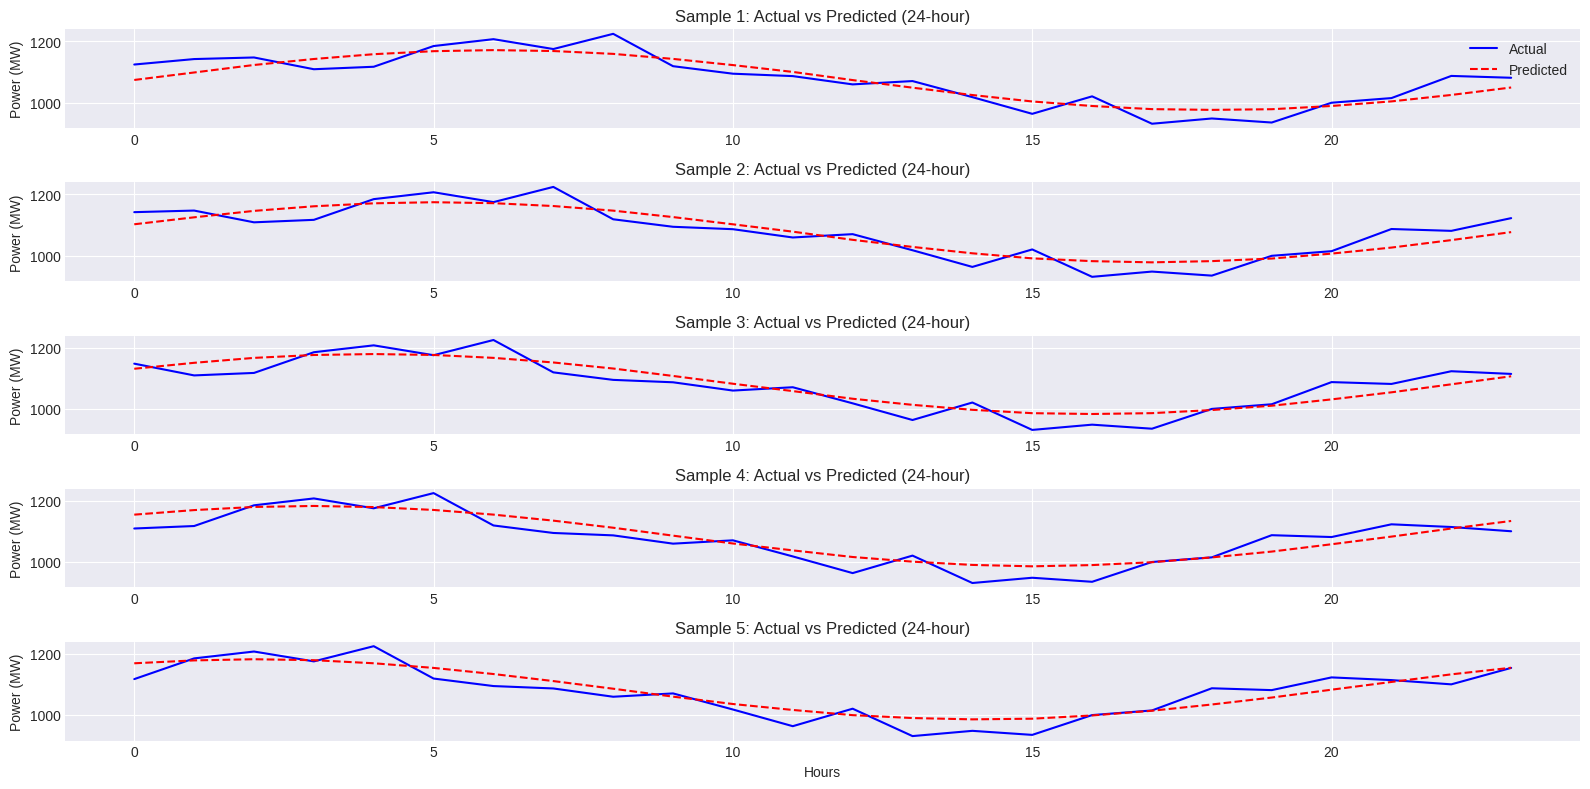

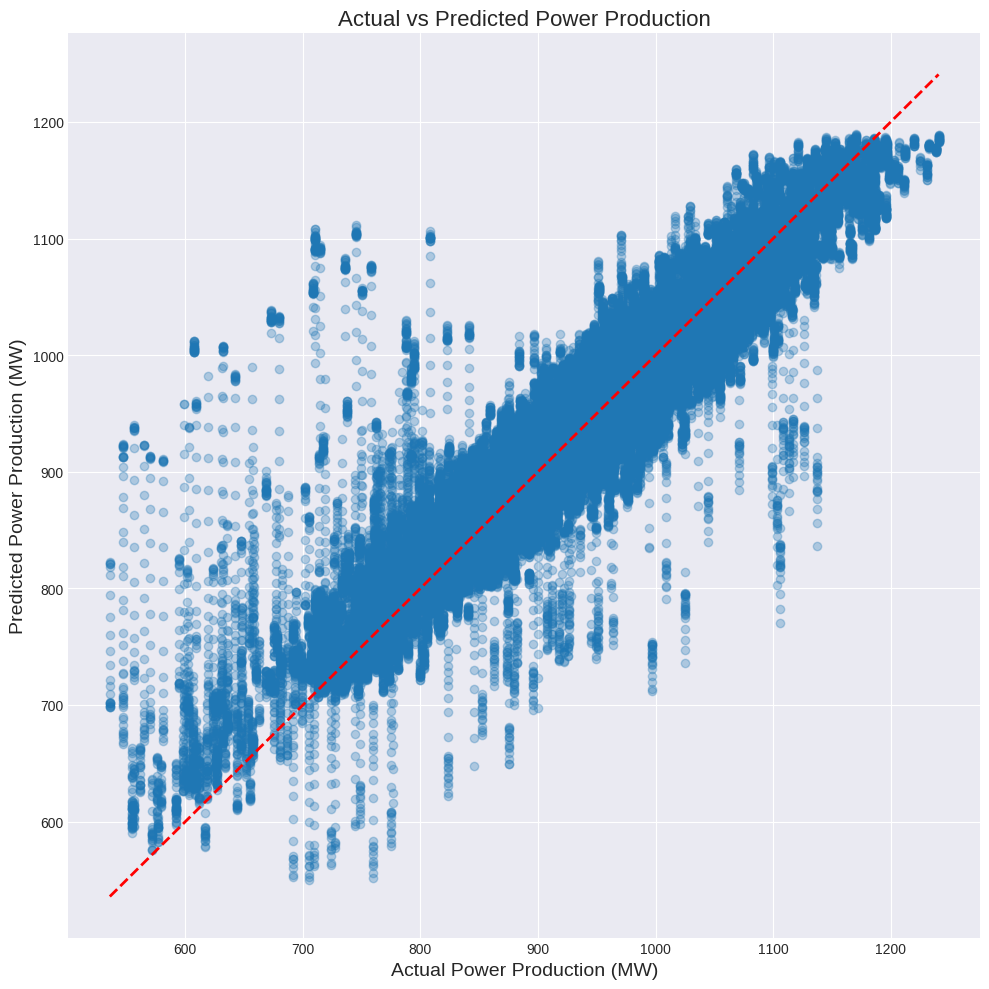

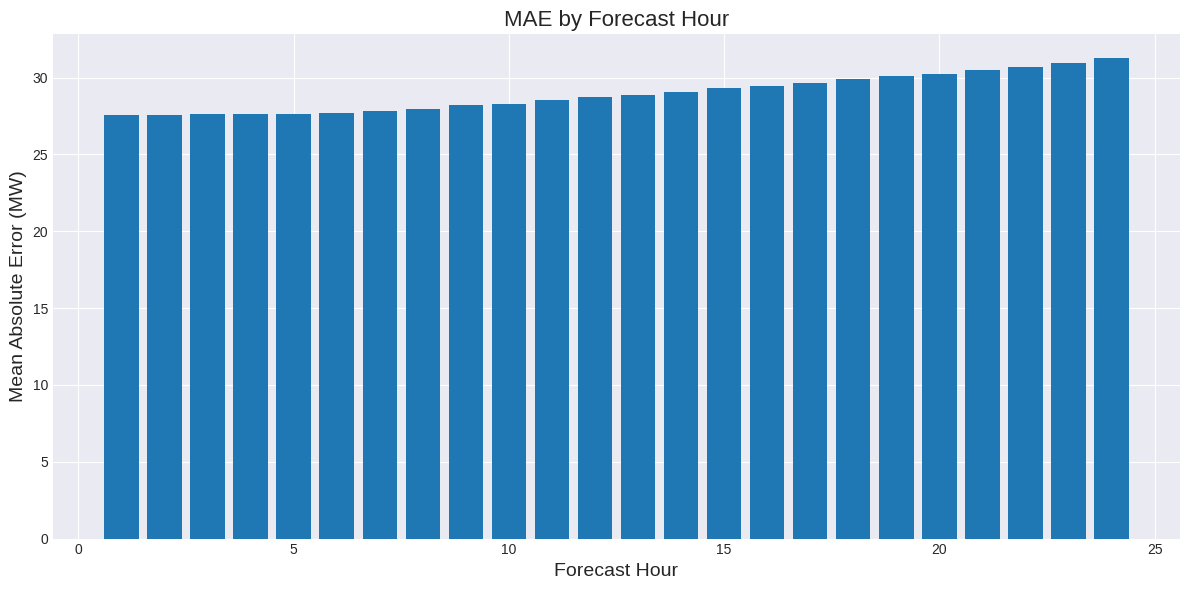

บันทึกผลการประเมินเรียบร้อยแล้ว


In [5]:
# ส่วนที่ 5: การประเมินโมเดล (Evaluation)
# ประเมินประสิทธิภาพของโมเดล LSTM ที่สร้างขึ้น

# โหลดข้อมูลและโมเดลที่ฝึกไว้ (หากต้องการรันแยก)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
import pandas as pd

try:
    # โหลดข้อมูลทดสอบ
    X_test = np.load('X_test.npy')
    y_test = np.load('y_test.npy')

    # โหลดโมเดล
    model = load_model('lstm_power_final_model.h5')

    # โหลด scaler
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    print("โหลดข้อมูลและโมเดลเรียบร้อย")
except FileNotFoundError:
    print("ไม่พบไฟล์ข้อมูลหรือโมเดล กรุณารันส่วนก่อนหน้านี้")

# พยากรณ์บนชุดข้อมูลทดสอบ
test_predictions = model.predict(X_test)
print(f"รูปร่างผลลัพธ์การพยากรณ์: {test_predictions.shape}")

# ฟังก์ชันสำหรับแปลงข้อมูลกลับเป็นค่าจริง
def inverse_transform_predictions(predictions, scaler, original_data_shape):
    """
    แปลงค่าพยากรณ์จากค่าที่ปรับไว้ (0-1) กลับเป็นค่าจริง

    Parameters:
    predictions (numpy.ndarray): ค่าพยากรณ์ที่ได้จากโมเดล
    scaler (MinMaxScaler): scaler ที่ใช้ในการปรับข้อมูลเดิม
    original_data_shape (int): จำนวนคอลัมน์ของข้อมูลเดิม

    Returns:
    numpy.ndarray: ค่าพยากรณ์ที่แปลงกลับเป็นค่าจริง
    """
    # สร้าง placeholder array ที่มีคอลัมน์เท่ากับข้อมูลต้นฉบับ
    dummy = np.zeros((len(predictions) * predictions.shape[1], original_data_shape))

    # ใส่ค่าพยากรณ์ลงในคอลัมน์แรก (คอลัมน์ power_production)
    dummy[:, 0] = predictions.reshape(-1)

    # Inverse transform
    dummy_inversed = scaler.inverse_transform(dummy)

    # เอาเฉพาะคอลัมน์ power_production และจัดรูปร่างให้ตรงกับรูปแบบเดิม
    return dummy_inversed[:, 0].reshape(predictions.shape)

# แปลงค่าพยากรณ์และค่าจริงกลับเป็นหน่วยเดิม
y_pred_actual = inverse_transform_predictions(test_predictions, scaler, X_test.shape[2])
y_test_actual = inverse_transform_predictions(y_test, scaler, X_test.shape[2])

# คำนวณค่าความผิดพลาด
mae = mean_absolute_error(y_test_actual.flatten(), y_pred_actual.flatten())
rmse = np.sqrt(mean_squared_error(y_test_actual.flatten(), y_pred_actual.flatten()))
mape = mean_absolute_percentage_error(y_test_actual.flatten(), y_pred_actual.flatten()) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f} MW')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f} MW')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# แสดงกราฟเปรียบเทียบค่าจริงกับค่าพยากรณ์
plt.figure(figsize=(16, 8))

# เลือกตัวอย่าง 5 วันแรกจากข้อมูลทดสอบเพื่อแสดงผล
days_to_show = 1  # แสดงเพียง 1 วัน (24 ชั่วโมง) ในแต่ละตัวอย่าง
samples = days_to_show * 24

for i in range(5):  # แสดง 5 ตัวอย่าง
    if i * samples < len(y_test_actual):
        plt.subplot(5, 1, i+1)
        plt.plot(y_test_actual[i, :samples], 'b-', label='Actual')
        plt.plot(y_pred_actual[i, :samples], 'r--', label='Predicted')
        plt.title(f'Sample {i+1}: Actual vs Predicted (24-hour)', fontsize=12)
        plt.ylabel('Power (MW)', fontsize=10)
        if i == 0:
            plt.legend(fontsize=10)

        # แสดงเฉพาะแกน x สำหรับกราฟสุดท้าย
        if i == 4:
            plt.xlabel('Hours', fontsize=10)

plt.tight_layout()
plt.show()

# แสดงแผนภาพการกระจายของค่าจริงกับค่าพยากรณ์ (Scatter plot)
plt.figure(figsize=(10, 10))
plt.scatter(y_test_actual.flatten(), y_pred_actual.flatten(), alpha=0.3)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2)
plt.title('Actual vs Predicted Power Production', fontsize=16)
plt.xlabel('Actual Power Production (MW)', fontsize=14)
plt.ylabel('Predicted Power Production (MW)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# คำนวณค่าความผิดพลาดตามช่วงเวลาต่างๆ
# แบ่งการพยากรณ์เป็นรายชั่วโมง
hour_mae = []
for i in range(y_test.shape[1]):  # 24 ชั่วโมง
    hour_mae.append(mean_absolute_error(y_test_actual[:, i], y_pred_actual[:, i]))

# แสดงกราฟ MAE ตามชั่วโมงที่พยากรณ์
plt.figure(figsize=(12, 6))
plt.bar(range(1, 25), hour_mae)
plt.title('MAE by Forecast Hour', fontsize=16)
plt.xlabel('Forecast Hour', fontsize=14)
plt.ylabel('Mean Absolute Error (MW)', fontsize=14)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# บันทึกผลการประเมิน
evaluation_results = {
    'MAE': mae,
    'RMSE': rmse,
    'MAPE': mape,
    'Hour_MAE': hour_mae
}

import json
with open('evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f)
print("บันทึกผลการประเมินเรียบร้อยแล้ว")

โหลดโมเดลและข้อมูลเรียบร้อย
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step

การพยากรณ์การผลิตไฟฟ้า 24 ชั่วโมงถัดไป (MW):
ชั่วโมงที่ 1: 1116.39 MW
ชั่วโมงที่ 2: 1136.51 MW
ชั่วโมงที่ 3: 1155.19 MW
ชั่วโมงที่ 4: 1168.97 MW
ชั่วโมงที่ 5: 1178.40 MW
ชั่วโมงที่ 6: 1182.12 MW
ชั่วโมงที่ 7: 1179.35 MW
ชั่วโมงที่ 8: 1171.34 MW
ชั่วโมงที่ 9: 1158.11 MW
ชั่วโมงที่ 10: 1139.07 MW
ชั่วโมงที่ 11: 1117.78 MW
ชั่วโมงที่ 12: 1095.89 MW
ชั่วโมงที่ 13: 1070.94 MW
ชั่วโมงที่ 14: 1048.71 MW
ชั่วโมงที่ 15: 1028.48 MW
ชั่วโมงที่ 16: 1011.60 MW
ชั่วโมงที่ 17: 1000.65 MW
ชั่วโมงที่ 18: 994.01 MW
ชั่วโมงที่ 19: 994.19 MW
ชั่วโมงที่ 20: 997.72 MW
ชั่วโมงที่ 21: 1008.05 MW
ชั่วโมงที่ 22: 1021.57 MW
ชั่วโมงที่ 23: 1039.47 MW
ชั่วโมงที่ 24: 1059.47 MW

ค่าเฉลี่ยการผลิตไฟฟ้าที่พยากรณ์: 1086.42 MW
ค่าสูงสุดของการผลิตไฟฟ้าที่พยากรณ์: 1182.12 MW
ค่าต่ำสุดของการผลิตไฟฟ้าที่พยากรณ์: 994.01 MW

ตัวอย่างการบันทึกผลการพยากรณ์:
             datetime  forecasted_power
0 2025-04-14 12:00:00       1116.389257
1 2025-04-14 13:00:00    

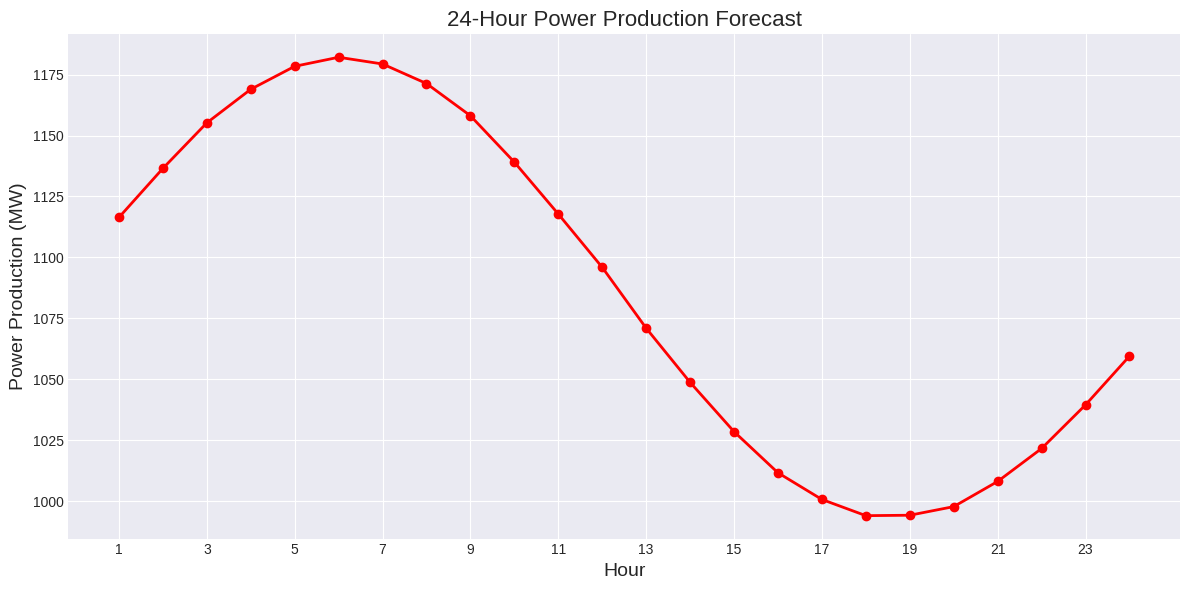


ตัวอย่างการพยากรณ์แบบอินเตอร์แอคทีฟ:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

ผลการพยากรณ์การผลิตไฟฟ้า 24 ชั่วโมงถัดไป:
ชั่วโมงที่ 1: 1116.39 MW
ชั่วโมงที่ 2: 1136.51 MW
ชั่วโมงที่ 3: 1155.19 MW
ชั่วโมงที่ 4: 1168.97 MW
ชั่วโมงที่ 5: 1178.40 MW
ชั่วโมงที่ 6: 1182.12 MW
ชั่วโมงที่ 7: 1179.35 MW
ชั่วโมงที่ 8: 1171.34 MW
ชั่วโมงที่ 9: 1158.11 MW
ชั่วโมงที่ 10: 1139.07 MW
ชั่วโมงที่ 11: 1117.78 MW
ชั่วโมงที่ 12: 1095.89 MW
ชั่วโมงที่ 13: 1070.94 MW
ชั่วโมงที่ 14: 1048.71 MW
ชั่วโมงที่ 15: 1028.48 MW
ชั่วโมงที่ 16: 1011.60 MW
ชั่วโมงที่ 17: 1000.65 MW
ชั่วโมงที่ 18: 994.01 MW
ชั่วโมงที่ 19: 994.19 MW
ชั่วโมงที่ 20: 997.72 MW
ชั่วโมงที่ 21: 1008.05 MW
ชั่วโมงที่ 22: 1021.57 MW
ชั่วโมงที่ 23: 1039.47 MW
ชั่วโมงที่ 24: 1059.47 MW


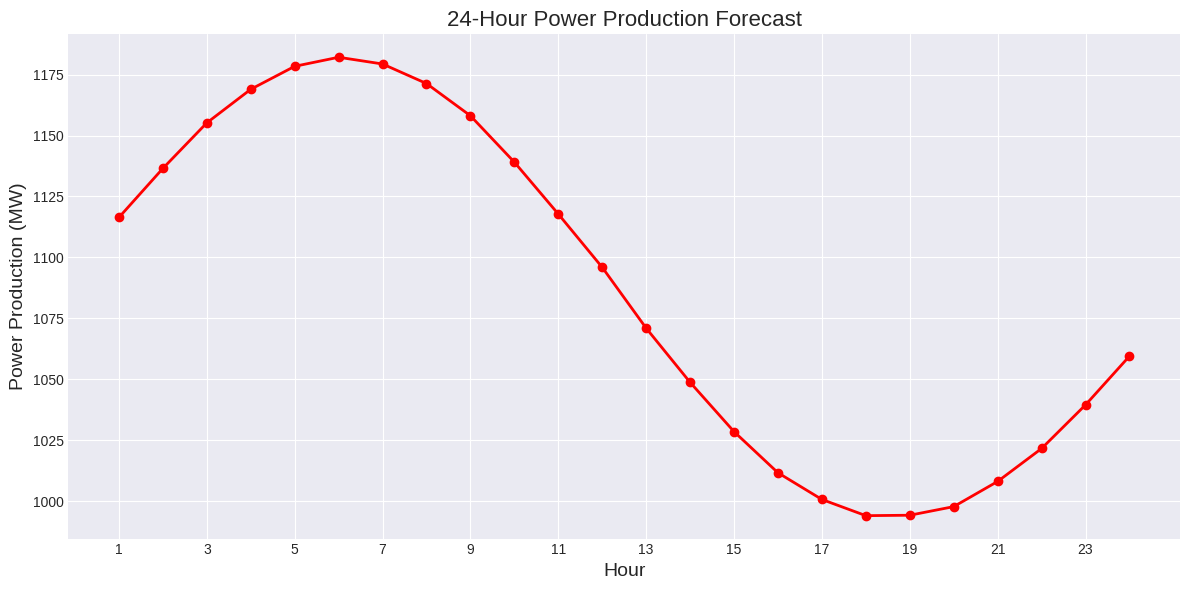


สรุปการนำโมเดลไปใช้งาน:
1. โมเดล LSTM สามารถพยากรณ์การผลิตไฟฟ้า 24 ชั่วโมงล่วงหน้าได้
2. ข้อมูลนำเข้าคือข้อมูลการผลิตไฟฟ้าและตัวแปรเกี่ยวกับเวลาย้อนหลัง 168 ชั่วโมง (7 วัน)
3. ผลลัพธ์คือค่าพยากรณ์การผลิตไฟฟ้ารายชั่วโมงสำหรับ 24 ชั่วโมงถัดไป
4. โมเดลสามารถนำไปใช้ในระบบการวางแผนการผลิตไฟฟ้าระยะสั้น
5. สามารถพัฒนาต่อเป็น API หรือระบบอัตโนมัติสำหรับการพยากรณ์แบบต่อเนื่อง

กรณีศึกษา: การวางแผนการผลิตไฟฟ้า 24 ชั่วโมงถัดไป
จากผลการพยากรณ์:
- ค่าเฉลี่ย: 1086.42 MW
- ค่าสูงสุด: 1182.12 MW ในชั่วโมงที่ 6
- ค่าต่ำสุด: 994.01 MW ในชั่วโมงที่ 18

คำแนะนำในการวางแผน:
1. เตรียมกำลังการผลิตหลักให้รองรับอย่างน้อย 1086 MW
2. เตรียมกำลังการผลิตสำรองเพิ่มเติมอีก 96 MW สำหรับช่วงชั่วโมงที่ 6
3. สามารถลดกำลังการผลิตลงในช่วงชั่วโมงที่ 18 เหลือ 994 MW
4. ควรพิจารณาปรับแผนการซ่อมบำรุงให้อยู่ในช่วงที่มีความต้องการต่ำ


In [6]:
# ส่วนที่ 6: การนำโมเดลไปใช้งาน (Deployment)
# แสดงตัวอย่างการนำโมเดล LSTM ไปใช้ในการพยากรณ์การผลิตไฟฟ้า

# โหลดโมเดลและ scaler ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from datetime import datetime, timedelta
import pickle
import json

# โหลดโมเดลและ scaler
try:
    model = load_model('lstm_power_final_model.h5')
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    X_test = np.load('X_test.npy')
    print("โหลดโมเดลและข้อมูลเรียบร้อย")
except FileNotFoundError:
    print("ไม่พบไฟล์โมเดลหรือข้อมูล กรุณารันส่วนก่อนหน้านี้")

# ฟังก์ชันสำหรับแปลงข้อมูลกลับเป็นค่าจริง
def inverse_transform_predictions(predictions, scaler, original_data_shape):
    """
    แปลงค่าพยากรณ์จากค่าที่ปรับไว้ (0-1) กลับเป็นค่าจริง

    Parameters:
    predictions (numpy.ndarray): ค่าพยากรณ์ที่ได้จากโมเดล
    scaler (MinMaxScaler): scaler ที่ใช้ในการปรับข้อมูลเดิม
    original_data_shape (int): จำนวนคอลัมน์ของข้อมูลเดิม

    Returns:
    numpy.ndarray: ค่าพยากรณ์ที่แปลงกลับเป็นค่าจริง
    """
    # สร้าง placeholder array ที่มีคอลัมน์เท่ากับข้อมูลต้นฉบับ
    dummy = np.zeros((len(predictions) * predictions.shape[1], original_data_shape))

    # ใส่ค่าพยากรณ์ลงในคอลัมน์แรก (คอลัมน์ power_production)
    dummy[:, 0] = predictions.reshape(-1)

    # Inverse transform
    dummy_inversed = scaler.inverse_transform(dummy)

    # เอาเฉพาะคอลัมน์ power_production
    return dummy_inversed[:, 0].reshape(predictions.shape)

# ฟังก์ชันสำหรับการพยากรณ์ข้อมูลใหม่
def forecast_next_24h(model, last_sequence, scaler, original_shape):
    """
    พยากรณ์การผลิตไฟฟ้า 24 ชั่วโมงถัดไป

    Parameters:
    model: โมเดล LSTM ที่ฝึกไว้แล้ว
    last_sequence: ข้อมูลลำดับเวลาล่าสุด (168 ชั่วโมง)
    scaler: scaler ที่ใช้ในการปรับข้อมูล
    original_shape: จำนวนคอลัมน์ของข้อมูลดิบ

    Returns:
    numpy.ndarray: ค่าพยากรณ์การผลิตไฟฟ้า 24 ชั่วโมงถัดไป
    """
    # พยากรณ์
    prediction = model.predict(np.expand_dims(last_sequence, axis=0))

    # แปลงกลับเป็นค่าจริง
    prediction_actual = inverse_transform_predictions(prediction, scaler, original_shape)

    return prediction_actual[0]

# เตรียมข้อมูลสำหรับการพยากรณ์
# ใช้ข้อมูลล่าสุดจากชุดทดสอบเป็นตัวอย่าง
last_sequence = X_test[-1]

# พยากรณ์ 24 ชั่วโมงถัดไป
forecast = forecast_next_24h(model, last_sequence, scaler, X_test.shape[2])

# แสดงผลการพยากรณ์
print("\nการพยากรณ์การผลิตไฟฟ้า 24 ชั่วโมงถัดไป (MW):")
for i, val in enumerate(forecast):
    print(f"ชั่วโมงที่ {i+1}: {val:.2f} MW")

# สรุปผลการพยากรณ์
print(f"\nค่าเฉลี่ยการผลิตไฟฟ้าที่พยากรณ์: {np.mean(forecast):.2f} MW")
print(f"ค่าสูงสุดของการผลิตไฟฟ้าที่พยากรณ์: {np.max(forecast):.2f} MW")
print(f"ค่าต่ำสุดของการผลิตไฟฟ้าที่พยากรณ์: {np.min(forecast):.2f} MW")

# สร้างวันที่และเวลาสำหรับการพยากรณ์
# สมมติว่าเวลาปัจจุบันเป็นเวลาล่าสุดของข้อมูล
current_time = datetime.now().replace(minute=0, second=0, microsecond=0)
forecast_dates = [current_time + timedelta(hours=i) for i in range(1, 25)]

# สร้าง DataFrame สำหรับบันทึกผลการพยากรณ์
forecast_df = pd.DataFrame({
    'datetime': forecast_dates,
    'forecasted_power': forecast
})

print("\nตัวอย่างการบันทึกผลการพยากรณ์:")
print(forecast_df.head())

# บันทึกผลการพยากรณ์
forecast_df.to_csv('power_forecast_24h.csv', index=False)
print("\nบันทึกผลการพยากรณ์เรียบร้อย")

# แสดงกราฟการพยากรณ์
plt.figure(figsize=(12, 6))
plt.plot(range(1, 25), forecast, 'ro-', linewidth=2)
plt.title('24-Hour Power Production Forecast', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Power Production (MW)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 25, 2))
plt.tight_layout()
plt.show()

# สร้างฟังก์ชันสำหรับการพยากรณ์แบบอินเตอร์แอคทีฟ
def interactive_forecasting(model, scaler, original_shape, custom_data=None):
    """
    ฟังก์ชันสำหรับพยากรณ์แบบอินเตอร์แอคทีฟ

    Parameters:
    model: โมเดล LSTM ที่ฝึกไว้แล้ว
    scaler: scaler ที่ใช้ในการปรับข้อมูล
    original_shape: จำนวนคอลัมน์ของข้อมูลดิบ
    custom_data: ข้อมูลที่กำหนดเอง (optional)
    """
    if custom_data is None:
        # ใช้ข้อมูลจากชุดทดสอบ (ตัวอย่าง)
        last_sequence = X_test[-1]
    else:
        # ใช้ข้อมูลที่กำหนดเอง
        last_sequence = custom_data

    # พยากรณ์
    forecast = forecast_next_24h(model, last_sequence, scaler, original_shape)

    # แสดงผล
    print("\nผลการพยากรณ์การผลิตไฟฟ้า 24 ชั่วโมงถัดไป:")
    for i, val in enumerate(forecast):
        print(f"ชั่วโมงที่ {i+1}: {val:.2f} MW")

    # แสดงกราฟ
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 25), forecast, 'ro-', linewidth=2)
    plt.title('24-Hour Power Production Forecast', fontsize=16)
    plt.xlabel('Hour', fontsize=14)
    plt.ylabel('Power Production (MW)', fontsize=14)
    plt.grid(True)
    plt.xticks(range(1, 25, 2))
    plt.tight_layout()
    plt.show()

    return forecast

# ตัวอย่างการเรียกใช้ฟังก์ชันแบบอินเตอร์แอคทีฟ
print("\nตัวอย่างการพยากรณ์แบบอินเตอร์แอคทีฟ:")
interactive_forecasting(model, scaler, X_test.shape[2])

# ตัวอย่างการสร้าง API สำหรับโมเดล (คอมเมนต์ไว้เพราะไม่สามารถรันได้บน Colab โดยตรง)
"""
จากส่วนนี้เป็นตัวอย่างโค้ดสำหรับการสร้าง API โดยใช้ Flask

from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/forecast', methods=['POST'])
def api_forecast():
    # รับข้อมูลจาก request
    data = request.json
    input_sequence = np.array(data['sequence'])

    # ตรวจสอบรูปร่างข้อมูล
    if input_sequence.shape != (168, 8):  # 7 วัน x 24 ชั่วโมง x 8 features
        return jsonify({'error': 'Invalid input shape, expected (168, 8)'}), 400

    # พยากรณ์
    forecast = forecast_next_24h(model, input_sequence, scaler, input_sequence.shape[1])

    # ส่งผลลัพธ์กลับ
    response = {
        'forecast': forecast.tolist(),
        'timestamp': datetime.now().isoformat(),
        'mean': float(np.mean(forecast)),
        'max': float(np.max(forecast)),
        'min': float(np.min(forecast))
    }

    return jsonify(response)

if __name__ == '__main__':
    app.run(debug=True)
"""

# สรุปการนำโมเดลไปใช้งาน
print("\nสรุปการนำโมเดลไปใช้งาน:")
print("1. โมเดล LSTM สามารถพยากรณ์การผลิตไฟฟ้า 24 ชั่วโมงล่วงหน้าได้")
print("2. ข้อมูลนำเข้าคือข้อมูลการผลิตไฟฟ้าและตัวแปรเกี่ยวกับเวลาย้อนหลัง 168 ชั่วโมง (7 วัน)")
print("3. ผลลัพธ์คือค่าพยากรณ์การผลิตไฟฟ้ารายชั่วโมงสำหรับ 24 ชั่วโมงถัดไป")
print("4. โมเดลสามารถนำไปใช้ในระบบการวางแผนการผลิตไฟฟ้าระยะสั้น")
print("5. สามารถพัฒนาต่อเป็น API หรือระบบอัตโนมัติสำหรับการพยากรณ์แบบต่อเนื่อง")

# กรณีศึกษา: การวางแผนการผลิตไฟฟ้า 24 ชั่วโมงถัดไป
print("\nกรณีศึกษา: การวางแผนการผลิตไฟฟ้า 24 ชั่วโมงถัดไป")
print("จากผลการพยากรณ์:")
print(f"- ค่าเฉลี่ย: {np.mean(forecast):.2f} MW")
print(f"- ค่าสูงสุด: {np.max(forecast):.2f} MW ในชั่วโมงที่ {np.argmax(forecast)+1}")
print(f"- ค่าต่ำสุด: {np.min(forecast):.2f} MW ในชั่วโมงที่ {np.argmin(forecast)+1}")
print("\nคำแนะนำในการวางแผน:")
print(f"1. เตรียมกำลังการผลิตหลักให้รองรับอย่างน้อย {np.mean(forecast):.0f} MW")
print(f"2. เตรียมกำลังการผลิตสำรองเพิ่มเติมอีก {np.max(forecast) - np.mean(forecast):.0f} MW สำหรับช่วงชั่วโมงที่ {np.argmax(forecast)+1}")
print(f"3. สามารถลดกำลังการผลิตลงในช่วงชั่วโมงที่ {np.argmin(forecast)+1} เหลือ {np.min(forecast):.0f} MW")
print("4. ควรพิจารณาปรับแผนการซ่อมบำรุงให้อยู่ในช่วงที่มีความต้องการต่ำ")